In [1]:
import pandas as pd
import json
import numpy as np
import datetime

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl 
%matplotlib inline
mpl.rcParams['patch.force_edgecolor'] = True
sns.set()

Import json file of user login timestamps. Each row is a single user login.

In [2]:
df_logins = pd.read_json('logins.json')
df_logins.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


# Part 1: EDA

## 1.1 Examine the data

#### Basic overview.

In [3]:
print("Earliest time in database: ", min(df_logins["login_time"]))
print("Latest time in database: ", max(df_logins["login_time"]), '\n')

print("Total entries: ", len(df_logins))

Earliest time in database:  1970-01-01 20:12:16
Latest time in database:  1970-04-13 18:57:38 

Total entries:  93142


All recorded dates are in 1970, beginning in January and ending in April (4-month period). Total of 93142 recorded user logins. Year is unusual - was there even a concept of "login" back in 1970? Data might be anonymized by changing the timestamps to another era, or these timestamps were cleaned/wrangled from some physical or digital ledger.

#### Freq across days, hours, months.

To check for possible data quality issues.

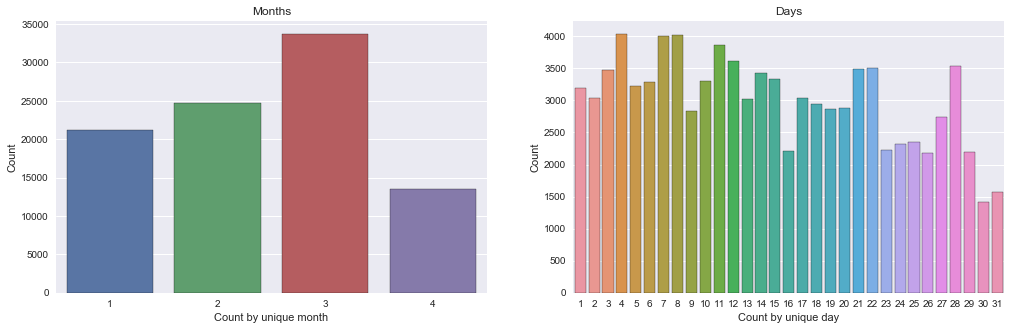

In [4]:
# Set up dataframe

datetimes = list(map(lambda x: x.date(), df_logins['login_time'].tolist())) # extract datetime objects

months = list(map(lambda x: x.month, datetimes)) 
days = list(map(lambda x: x.day, datetimes))

df_datetimes = pd.DataFrame({'month':months, 'day':days}) # Convert to dataframe, with separate month & day columns

# Plot

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(17,5))
# Count by month
df1 = df_datetimes.groupby('month').count()
sns.barplot(x=df1.index.tolist(), y="day", data=df1, ax=ax1);
ax1.set(xlabel='Count by unique month', ylabel="Count", title="Months");

# Count by day
df2 = df_datetimes.groupby('day').count()
sns.barplot(x=df2.index.tolist(), y="month", data=df2, ax=ax2);
ax2.set(xlabel='Count by unique day', ylabel="Count", title="Days");

Some observations:
- March has the most number of user logins. April has much fewer, possibly because data collection was truncated before month ended.
- Last 2 days of month have the least number of user logins.

No glaring data quality issues though, which is good.

## 1.2 Aggregating intervals - 15 min

Aggregate login counts based on 15-min intervals. 

In [5]:
df = pd.DataFrame.copy(df_logins) # make copy of dataframe to work with
df.set_index('login_time', inplace=True) # set index to be the timestamps, to allow aggregation
df['count'] = 1 # each timestamp has 1 count
df_15 = df.resample('15T').sum() # aggregate by 15-min intervals
df_15.head()

,count
login_time,
1970-01-01 20:00:00,2
1970-01-01 20:15:00,6
1970-01-01 20:30:00,9
1970-01-01 20:45:00,7
1970-01-01 21:00:00,1


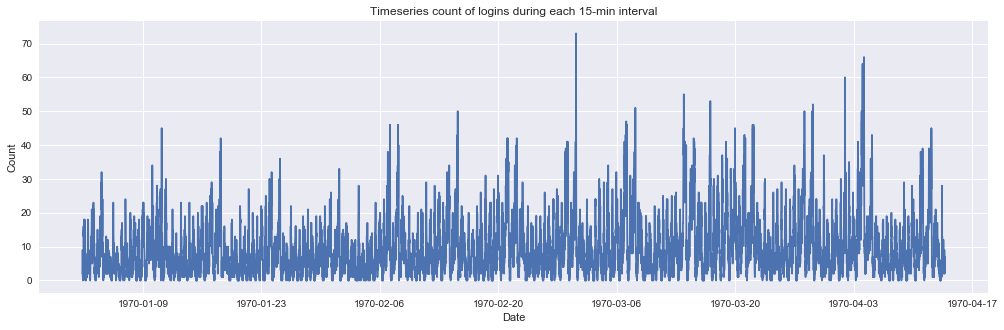

In [6]:
plt.figure(figsize=(17,5));
plt.plot(df_15);
plt.xlabel('Date')
plt.ylabel('Count')
plt.title('Timeseries count of logins during each 15-min interval');

We see a spike in logins near the beginning of March.

The plot is difficult to interpret beyond just large chunks of dates. We will narrow the figure down to different time-levels.

#### Plot different time intervals

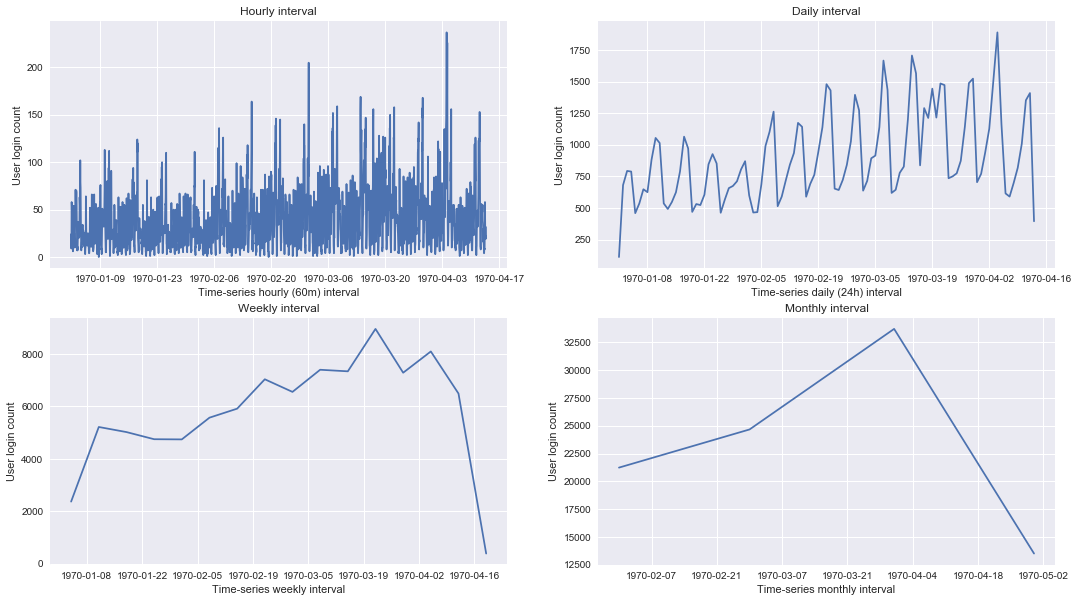

In [7]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(18,10));

# 60-min interval
ax1.plot(df.resample('60T').sum());
ax1.set(xlabel='Time-series hourly (60m) interval', ylabel='User login count', title='Hourly interval');

# Daily interval
ax2.plot(df.resample('D').sum());
ax2.set(xlabel='Time-series daily (24h) interval', ylabel='User login count', title='Daily interval');

# Weekly interval
ax3.plot(df.resample('W').sum());
ax3.set(xlabel='Time-series weekly interval', ylabel='User login count', title='Weekly interval');

# Monthly interval
ax4.plot(df.resample('M').sum());
ax4.set(xlabel='Time-series monthly interval', ylabel='User login count', title='Monthly interval');

<b>Big picture</b>: On the hourly and daily level, it's still difficult to picture any patterns due to the constrained x-axis. 

<b>Cycles</b>: However, even from this bird's eye view we can see a general cyclic pattern emerging from the "Daily interval" figure - it seems there might be certain hours of the day at which there are more user logins than other parts of day, and this cycle repeats itself each day, even though intensity varies.

#### Zoom in on a single day's cycle

Zoom in on the hourly interval of a single day, so that we can better picture fluctuations throughout the day that we couldn't see in previous figure. These fluctuations probably make up a single cycle, which we see repeating each day (albeit with differing intensities). We'll randomly pick Feb 4, 2017.

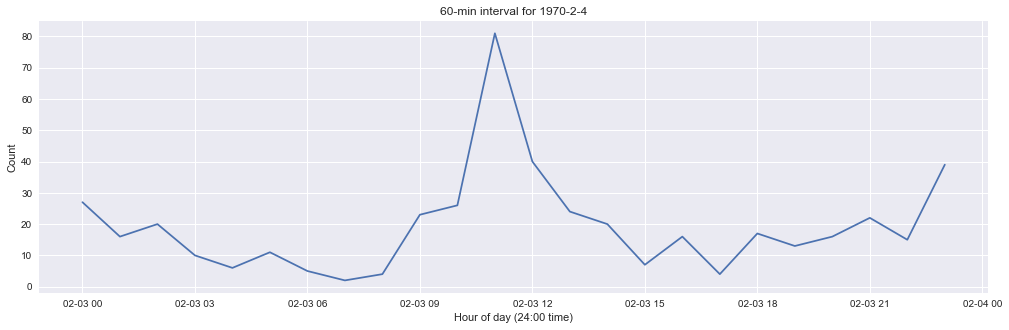

In [8]:
# Grab all logins on Feb 4, 1970
mask = (df_logins['login_time'] > datetime.date(1970, 2, 3)) & (df_logins['login_time'] <= datetime.date(1970, 2, 4))
df_day = df_logins[mask]

# Aggregate into 60-min intervals
df = pd.DataFrame.copy(df_day) 
df.set_index('login_time', inplace=True) 
df['count'] = 1 
df_60 = df.resample('60T').sum()

# Plot
plt.figure(figsize=(17,5));
plt.plot(df_60);
plt.xlabel('Hour of day (24:00 time)');
plt.ylabel('Count');
plt.title('60-min interval for 1970-2-4');

Now we can picture the fluctuations. In this particular geographic location: 
- Morning and evening have lowest user logins. 
- Logins pick up around 9 AM (possible: rush hour to work) and peak right before noon (possible: rush hour to lunch). 
- Then they drop off, although they may pick up slightly before midnight (possible: returning from "going out" hours).

# Part 2: Experiment and metrics design

The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on
weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active
during the day. On weekends, there is reasonable activity in both cities.

However, a toll bridge, with a two way
toll, between the two cities causes driver partners to tend
to be exclusive to each city. The Ultimate managers of city operations for the two cities have
proposed an experiment to encourage driver partners to be available in both cities, by
reimbursing all toll costs.

### 1. What would you choose as the key measure of success of this experiment in encouraging driver partners to serve both cities, and why would you choose this metric?

Determine the change in pre- and post-reimbursement number of times driver has crossed the bridge, since this will indicate whether there is an increase, decrease, or no change in how often driver partners served both cities after the experiment.

A significant post-reimbursement <i>increase</i> in driver crossings supports the experiment's success - driver partners tended to serve both cities <i>more often</i> after the experiment's introduction.

### 2. Describe a practical experiment you would design to compare the effectiveness of the proposed change in relation to the key measure of success. Please provide details on:

#### Implementing experiment

Conduct a one-sided, 1-sample z-test, assuming sample size > 30 drivers. Compare number driver bridge crossings (where a crossing = crossing the bridge + serving crossed-to city) pre- and post-reimbursement. 

- $h_0$: No difference in driver bridge crossings, after toll reimbursement experiment.
- $h_a$: Increase in driver bridge crossings, after toll reimbursement experiment.

Null hypothesis distribution is simply the distribution of driver crossings <i>before</i> toll reimbursement experiment.

1. Calculate z-score of average frequency of drivers serving both cities, post-reimbursement experiment.
2. Set $a$=0.05. Determine if z-score's p-value falls below this significance threshold.

#### Interpreting results

If p-value < 0.05, then the post-reimbursement crossings are so high that it's unlikely to occur under the null hypothesis of pre-reimbursement crossings. This result would support a significant increase in driver bridge crossings after the toll reimbursement is introduced, indicating that this policy was a success.

#### Caveats & recommendations 
However, the caveat is that $a$ significance levels are set arbitrarly and p-values fluctuate depending on sample size. So depending on how wide of a margin the post-reimbursement increase is, our experiment could either support or reject the policy. 

As a result, I recommend only considering the policy a success if the margin is wide enough (and p-value far below 0.05) that it is obvious that a significant post-reimbursement increase has occurred even in the midst of the aforementioned fluctuations.

# Part 3: Predictive modeling

In [9]:
df_users = json.load(open('ultimate_data_challenge.json')) # load json (produces dict)
df_users = pd.DataFrame(df_users) # convert json dict to dataframe
print('Number of users: ', len(df_users))
df_users.head()

Number of users:  50000


,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4


## 1. Data cleaning, exploratory analysis, visualizations 

Perform any cleaning, exploratory analysis, and/or visualizations to use the provided data for this analysis (a few sentences/plots describing your approach will suffice). What fraction of the observed users were retained?

#### Get cutoff for "retained users"

Users are retained if, at the time of pulling data, they were active in the preceding 30 days.

In [10]:
from datetime import timedelta
from dateutil import parser

# Get latest date that data was pulled
df_users['last_trip_date'] = pd.to_datetime(df_users['last_trip_date']) # convert 'last_trip_date' column to datetime
date_pulled = max(df_users['last_trip_date']) # get max = approximation of when data was pulled

# Get cutoff for earliest active date to meet "retained" criteria
retain_cutoff = date_pulled - timedelta(days=30)

print("Cut-off for 'retained users': ", retain_cutoff)

Cut-off for 'retained users':  2014-06-01 00:00:00


#### Get fraction of observed users retained

In [11]:
df_retained = df_users[df_users['last_trip_date'] >= retain_cutoff]
print("Fraction of observed users retained: ", len(df_retained) / len(df_users))

Fraction of observed users retained:  0.37608


# 2. Build a predictive model

Build a predictive model to help Ultimate determine whether or not a user will be active in their 6th month on the system. Discuss why you chose your approach, what alternatives you considered, and any concerns you have. How valid is your model? Include any key indicators of model performance.

#### Get users still active in their 6th month in system

In [12]:
# Set up
df_users['signup_date'] = pd.to_datetime(df_users['signup_date']) # convert dates to datetime objects
month_6 = df_users['signup_date'] + timedelta(days=151) # set minimum date of last ride to qualitfy as "active in their 6th mo"

# Get users active in their 6th month in system
active_idx = [idx for idx, s in enumerate(df_users['last_trip_date']) if s > month_6[idx]] # their their indices in database

# Append data to our database (useful for data viz later)
df_users['active'] = 0 # set default to 0
df_users.loc[active_idx, 'active'] = 1 # set active users to 1

print("Number of active users: ", len(active_idx))
print("Number of inactive users: ", len(df_users) - len(active_idx))
print("Percent active users: ", len(active_idx)/len(df_users))

Number of active users:  11694
Number of inactive users:  38306
Percent active users:  0.23388


Only ~23% of users are active. We probably can't rely on accuracy alone for determining how effective our model is - rather, will need metrics such as % false positives and false negatives.

## 2.1 Data cleaning, preprocessing, & EDA

Clean data/fill in missing data, feature scaling, drop irrelevant features, etc while inspecting the data.

### 2.1.1. Convert columns w/ string values to int

Inspect which columns consist of string values.

In [13]:
df_users.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct,active
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2,0
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0,0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0,0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0,1
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4,0


Check number of unique values in each of these columns.

In [14]:
print("city: ", df_users['city'].unique())
print("phone: ", df_users['phone'].unique())
print("ultimate_black_user: ", df_users['ultimate_black_user'].unique())

city:  ["King's Landing" 'Astapor' 'Winterfell']
phone:  ['iPhone' 'Android' None]
ultimate_black_user:  [ True False]


Convert to int.
- <b>city</b>: {'Winterfell': 1, 'Astapor': 2, "King's Landing": 3}
- <b>phone</b>: {"iPhone": 1, "Android": 2, "None": 0}
- <b>ultimate_black_user</b>: {"True": 1, "False": 0}

In [15]:
# Convert cities
cities = {'Winterfell': 1, 'Astapor': 2, "King's Landing": 3}
df_users['city'] = df_users['city'].map(lambda x: cities[x])

# Convert phones
phones = {"iPhone": 1, "Android": 2}
df_users['phone'] = df_users['phone'].map(lambda i: phones[i] if i is not None else 0)

# Convert ultimate black status

df_users['ultimate_black_user'] = df_users['ultimate_black_user'].map(lambda b: 1 if b == True else 0)

### 2.1.2 Replace missing values
There's missing values in some of the columns. To deal with these missing values, we'll replace them with the column's mean.

In [16]:
df_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 13 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      49799 non-null float64
avg_rating_of_driver      41878 non-null float64
avg_surge                 50000 non-null float64
city                      50000 non-null int64
last_trip_date            50000 non-null datetime64[ns]
phone                     50000 non-null int64
signup_date               50000 non-null datetime64[ns]
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
ultimate_black_user       50000 non-null int64
weekday_pct               50000 non-null float64
active                    50000 non-null int64
dtypes: datetime64[ns](2), float64(6), int64(5)
memory usage: 5.0 MB


In [17]:
df_users['avg_rating_by_driver'].fillna(df_users['avg_rating_by_driver'].mean(), inplace=True)
df_users['avg_rating_of_driver'].fillna(df_users['avg_rating_of_driver'].mean(), inplace=True)

### 2.1.3 Determine meaningful features to keep

Since some of our features are encoded differently and others might be inter-related, we should determine which features to throw out of our model to simplify it and minimize confounding.

#### Inter-feature correlations

Make sure none of our features are correlated with one another. For convenience, however, our correlation matrix also includes a row/column for 'active' users - this allows us to easily visualize whether any individual features strongly predict 'active' users.

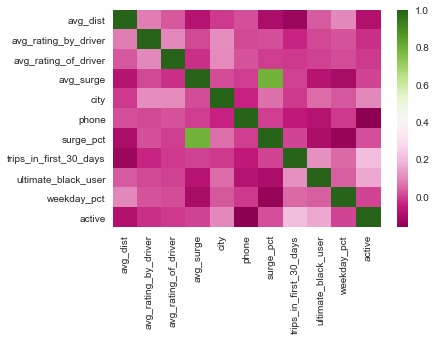

In [18]:
sns.heatmap(df_users.corr(), cmap="PiYG");

Based on these results, we throw out:
- <b>'surge_pct'</b> and <b>'avg_surge'</b>: The only features w/ high inter-correlation are 'surge_pct' and 'avg_surge', which makes sense. Users who tend to take trips during surge will have higher % trips w/ surge ('surge_pct') and higher average surge ('avg_surge'). Since neither are strongly correlated with 'active' users, we drop these to avoid confounding our model.
- <b>'phone'</b>: Very low correlation (~0) with 'active' users. Additionally, it might confound our model since its values are encoded by an arbitrary binary conversion and most of our features are continuous.

#### Inspect select features more closely

There are a few discrete features we're unsure about: <b>'city'</b> and <b>'ultimate_black_user'</b>. We'd like to throw them out if they don't seem significant in contributing to the prediction of 'active' user (since discrete features might confound our model of majority continuous features). Let's inspect them more closely.

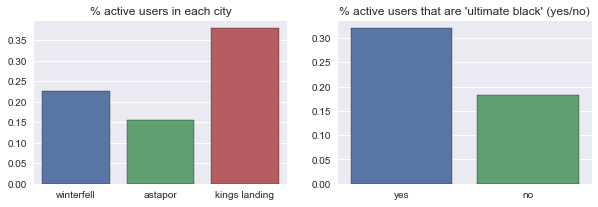

In [19]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10,3))

# % active users by city

df1 = df_users[df_users['city']==1]
df2 = df_users[df_users['city']==2]
df3 = df_users[df_users['city']==3]

active1 = len(df1[df1['active']==1])/len(df1)
active2 = len(df2[df2['active']==1])/len(df2)
active3 = len(df3[df3['active']==1])/len(df3)

g = sns.barplot(x = ['winterfell', 'astapor', 'kings landing'], y = [active1, active2, active3], ax=ax1);
g.set_title('% active users in each city');

# % active users by "ultimate black" status

df1 = df_users[df_users['ultimate_black_user']==1]
df2 = df_users[df_users['ultimate_black_user']==0]

active1 = len(df1[df1['active']==1])/len(df1)
active2 = len(df2[df2['active']==1])/len(df2)

g = sns.barplot(x = ['yes', 'no'], y = [active1, active2], ax=ax2);
g.set_title("% active users that are 'ultimate black' (yes/no)");

They still might be worth keeping - there seem to be differences, although whether these differences are significant remains unclear.

### 2.1.4 Drop selected features

We've determined that we should drop <b>'surge_pct', 'avg_surge'</b>, and <b>'phone'</b>. 

We also would like to drop <b>'last_trip_date'</b> and <b>'signup_date'</b>, since these were used to determine whether the user was active and may no longer be useful. We might be interested in the # of days between last trip & signup date, but this is susceptible to a lot of confounding factors so for the sake of simplicity we just drop it.

In [20]:
df_users.drop(['surge_pct', 'avg_surge', 'phone', 'last_trip_date', 'signup_date'], inplace=True, axis=1)

Here is our dataset now:

In [21]:
df_users.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,city,trips_in_first_30_days,ultimate_black_user,weekday_pct,active
0,3.67,5.0,4.7,3,4,1,46.2,0
1,8.26,5.0,5.0,2,0,0,50.0,0
2,0.77,5.0,4.3,2,3,0,100.0,0
3,2.36,4.9,4.6,3,9,1,80.0,1
4,3.13,4.9,4.4,1,14,0,82.4,0


### 2.1.5 Scale features

Inspect distribution of data, determine which feature scaler is best to use, then scale features.

#### Check distribution of features.

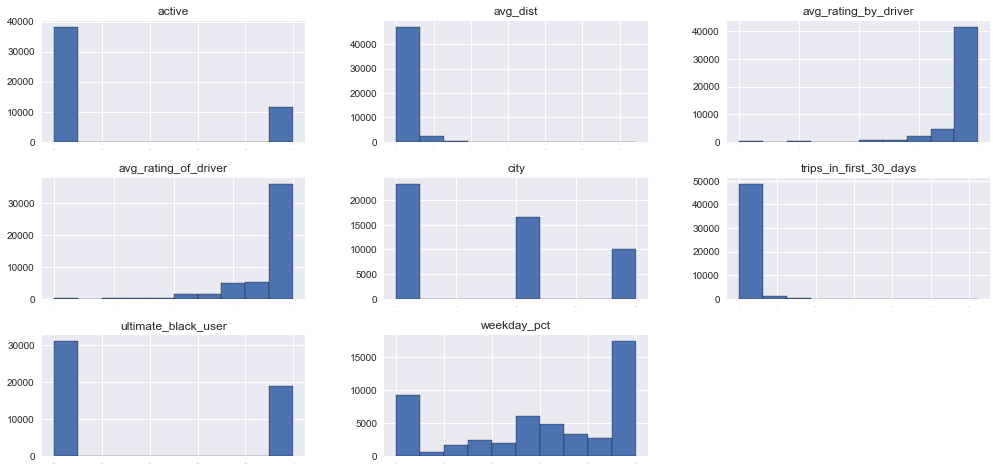

In [22]:
df_users.hist(sharex=False, sharey=False, xlabelsize=1, figsize=(17,8));

#### Which feature scaler?
There are a couple of feature scalers we could use. 
- <b>Standard scaler</b>. Assumes feature is normally distributed, scales them to center around 0 and standard deviation of 1. However, from the above plot we can see almost none of our features are normally distributed (especially our discretely coded features)
- <b>Min-max scaler</b>. Shrinks range of each feature to (0,1) or (-1,1) if there are negative values. Works better for data that aren't normally distributed. 

So we'll use [MinMaxScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html).

In [23]:
from sklearn.preprocessing import MinMaxScaler

x = df_users.drop('active', axis=1)
y = df_users['active']

scaler = MinMaxScaler()
scaler.fit(x)
x = scaler.fit_transform(x)

## 2.2 Modeling

We are trying to predict whether a user will still be active or not after 6 months in the system - i.e. a binary classifier. We'll first try a few different classifiers, pick the best-performing one, then optimize hyperparameters to improve performance. 

### 2.2.1 Determining cross-validation scores: importance of FP

<b><u>Priority for Ultimate's business</u></b>: Ultimate's priority is probably to detect whether a customer will churn. The cost invested in preventing them from churning probably involves increased marketing and alerts to prevent churning behavior. 

<b><u>False positives</u></b>: As a result, we are probably more concerned about false positives rather than false negatives - it is safer to target ads to anyone remotely at-risk for churning. The worst that could happen is that an 'active' user is incorrectly labeled as 'inactive' and therefore receives targeted ads that an at-risk churner would receive (i.e. because they were a false negative). 

Subjectively, we consider that acceptable and not likely to affect 'active' users - although would recommend monitoring whether it does in the future, since this is a crucial assumption. 

In short, <b><i>we want to minimize our rate of false positives</b></i>, i.e. minimize # of churners (not active) who are incorrectly predicted to be non-churners (active). Since these are the customers that Ultimate are probably actually interested in targeting. We should examine the confusion matrix resulting from each of our ML approaches.

<b><u>Threshold for false negatives</u></b>: However, we don't want a situation in which too many 'active' users get annoying ads. Otherwise there might end up being a significant number of them who churn later on. So we should look out for false negatives as well.

In [229]:
# Split the data into train & test sets before modeling

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

X_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=99)

### 2.2.2 Logistic regression

Since we were unsure of whether some of the features will be important, we use regularization to reduce the weight of less important features. Even more stringently, we use L1 (Lasso) regression in the case that unimportant features can be eliminated from the model.

In [257]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

# Instantiate model
model = LogisticRegression(penalty='l1') # instantiate logreg w/ l1 regularization
model.fit(X_train, y_train)
y_pred = model.predict(x_test)

# Generate confusion matrix
print('Confusion matrix: ')
print(confusion_matrix(y_test, y_pred))

Confusion matrix: 
[[11230   202]
 [ 3280   288]]


202 of churners were incorrectly labeled as 'active' users. There are also many active users misclassified as churners (false negatives, 3280). Let's move on to the other ML approaches to see how they compare.

### 2.2.2 Decision trees

Test different methods based on decision trees: 1) regular decision tree, 2) bagging, 3) random forest, 4) boosting. Then pick the one with the best metrics.

#### Make custom scoring function

We are most interested in reducing false positives (churned users incorrectly identified as 'active'), while ensuring low false negative rates (active users incorrectly identified as churned) since too many active users would be incorrectly spammed to "retain" them. 

We want to identify any model that is an improvement over our previous logreg model (fp: 202, fn: 3280). So we write a custom scoring function that takes any model with fp < 202, fn < 3280. Then, from this group of models, [GridSearchCV](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) identifies the model with lowest total fp + fn as the "best" model.

In [198]:
#from sklearn.metrics import roc_curve, auc
from sklearn.metrics import make_scorer

# Define scorer
def false_total(y_true, y_pred):
    matrix = confusion_matrix(y_true, y_pred)
    false_p = matrix[0,1]
    false_n = matrix[1,0]
    if ((false_p < 202) & (false_n < 2000)):
        falses = (false_p+false_n)/sum(sum(matrix))
        return falses
    else:
        falses = 1
        return falses

# Make scorer
scorer = make_scorer(false_total, greater_is_better=False)

#### Regular decision tree

In [199]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings('ignore')

# Decision tree
score = scorer
tuned_parameters = {'max_depth':range(2,7)}
model = DecisionTreeClassifier(min_samples_split=100, max_features='sqrt', random_state=99)

clf = GridSearchCV(estimator=model, param_grid=tuned_parameters, scoring=scorer, cv=5)
clf.fit(X_train, y_train)

print("Best parameters set found on development set:")
print(clf.best_params_, '\n')
print("Grid scores on development set:")
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
print()
print("Detailed classification report:")
y_true, y_pred = y_test, clf.predict(x_test)
print(confusion_matrix(y_true, y_pred), '\n')

Best parameters set found on development set:
{'max_depth': 2} 

Grid scores on development set:
-0.232 (+/-0.000) for {'max_depth': 2}
-0.232 (+/-0.000) for {'max_depth': 3}
-1.000 (+/-0.000) for {'max_depth': 4}
-0.846 (+/-0.614) for {'max_depth': 5}
-0.843 (+/-0.629) for {'max_depth': 6}

Detailed classification report:
[[11432     0]
 [ 3568     0]] 



Although we have 0 churned users incorrectly identified as 'active' now, we have too many 'active' users incorrectly identified as churners. That means a lot of active customers will receive spam.  We'll move on to other methods that are typically improved versions of decision trees.

#### Bagging

Constructs multiple trees and picks best-performing one.

In [210]:
%%time

from sklearn.ensemble import BaggingClassifier

score = scorer
tuned_parameters = {'n_estimators':range(30,91,10)}
model = BaggingClassifier(random_state=99)

clf = GridSearchCV(estimator=model, param_grid=tuned_parameters, scoring=score, cv=5)
clf.fit(X_train, y_train)

print("Best parameters set found on development set:")
print(clf.best_params_, '\n')
print("Grid scores on development set:")
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
print()
print("Detailed classification report:")
y_true, y_pred = y_test, clf.predict(x_test)
print(confusion_matrix(y_true, y_pred), '\n')

Best parameters set found on development set:
{'n_estimators': 30} 

Grid scores on development set:
-1.000 (+/-0.000) for {'n_estimators': 30}
-1.000 (+/-0.000) for {'n_estimators': 40}
-1.000 (+/-0.000) for {'n_estimators': 50}
-1.000 (+/-0.000) for {'n_estimators': 60}
-1.000 (+/-0.000) for {'n_estimators': 70}
-1.000 (+/-0.000) for {'n_estimators': 80}
-1.000 (+/-0.000) for {'n_estimators': 90}

Detailed classification report:
[[10081  1351]
 [ 2269  1299]] 



False negatives (active users incorrectly identified as churned), but we still have 1351 false positives (churned users we missed and incorrectly labled as 'active').

#### Random forest

Constructs multiple decision trees (specified by 'n_estimators') and picks best one. When forming a tree, at each node a subset of features are randomly selected out of the total features. The best split feature from this subset is used to split the node (vs. bagging, where all features considered for splitting a node). 

In [172]:
%%time

from sklearn.ensemble import RandomForestClassifier

score = scorer
tuned_parameters = {'n_estimators':range(20,91,10), 'max_depth':range(2,7), 'min_samples_split':range(100,1000,200)}
model = RandomForestClassifier(random_state=99)

clf = GridSearchCV(estimator=model, param_grid=tuned_parameters, scoring=score, cv=5)
clf.fit(X_train, y_train)

print("Best parameters set found on development set:")
print(clf.best_params_, '\n')
print("Grid scores on development set:")
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
print()
print("Detailed classification report:")
y_true, y_pred = y_test, clf.predict(x_test)
print(confusion_matrix(y_true, y_pred), '\n')

Best parameters set found on development set:
{'max_depth': 4, 'min_samples_split': 100, 'n_estimators': 30} 

Grid scores on development set:
-0.232 (+/-0.000) for {'max_depth': 2, 'min_samples_split': 100, 'n_estimators': 20}
-0.232 (+/-0.000) for {'max_depth': 2, 'min_samples_split': 100, 'n_estimators': 30}
-0.232 (+/-0.000) for {'max_depth': 2, 'min_samples_split': 100, 'n_estimators': 40}
-0.232 (+/-0.000) for {'max_depth': 2, 'min_samples_split': 100, 'n_estimators': 50}
-0.232 (+/-0.000) for {'max_depth': 2, 'min_samples_split': 100, 'n_estimators': 60}
-0.232 (+/-0.000) for {'max_depth': 2, 'min_samples_split': 100, 'n_estimators': 70}
-0.232 (+/-0.000) for {'max_depth': 2, 'min_samples_split': 100, 'n_estimators': 80}
-0.232 (+/-0.000) for {'max_depth': 2, 'min_samples_split': 100, 'n_estimators': 90}
-0.232 (+/-0.000) for {'max_depth': 2, 'min_samples_split': 300, 'n_estimators': 20}
-0.232 (+/-0.000) for {'max_depth': 2, 'min_samples_split': 300, 'n_estimators': 30}
-0.232 

This is slightly better than all the models we've used so far, including the logreg model. Let's try [AdaBoost](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html) to see if we can further improve.

#### AdaBoost

Gives weight to the misclassified data points. Might be useful since we have a disproportionately small number of active users that might be misclassified.

In [212]:
%%time

from sklearn.ensemble import AdaBoostClassifier

score = scorer
tuned_parameters = {'n_estimators':range(20,91,10)}
model = AdaBoostClassifier(random_state=99)

clf = GridSearchCV(estimator=model, param_grid=tuned_parameters, scoring=score, cv=5)
clf.fit(X_train, y_train)

print("Best parameters set found on development set:")
print(clf.best_params_, '\n')
print("Grid scores on development set:")
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
print()
print("Detailed classification report:")
y_true, y_pred = y_test, clf.predict(x_test)
print(confusion_matrix(y_true, y_pred), '\n')

Best parameters set found on development set:
{'n_estimators': 20} 

Grid scores on development set:
-1.000 (+/-0.000) for {'n_estimators': 20}
-1.000 (+/-0.000) for {'n_estimators': 30}
-1.000 (+/-0.000) for {'n_estimators': 40}
-1.000 (+/-0.000) for {'n_estimators': 50}
-1.000 (+/-0.000) for {'n_estimators': 60}
-1.000 (+/-0.000) for {'n_estimators': 70}
-1.000 (+/-0.000) for {'n_estimators': 80}
-1.000 (+/-0.000) for {'n_estimators': 90}

Detailed classification report:
[[10659   773]
 [ 2523  1045]] 

Wall time: 58.7 s


The number of fn is much lower, which means fewer active users will be incorrectly identified as churners/spammed to "retain" them. However, the number of fp is higher than logreg and our optimal random forest model.

### 2.2.3 Naive bayes

Finally, we'll try the Naive bayes classifier. 

It is rooted in probability ([Bayes theorem](https://en.wikipedia.org/wiki/Bayes%27_theorem)) and generates predictions based on past data - given prior training data with features and labelled outcomes, what can we predict with our set of test observations and their features? The label it predicts for each observation is based on its calculation of the likeliest out of the possible labels.

In [230]:
from sklearn.naive_bayes import MultinomialNB

# Instantiate a Multinomial Naive Bayes classifier: nb_classifier
nb_classifier = MultinomialNB()

# Fit the classifier to the training data
nb_classifier.fit(X_train, y_train)

# Create the predicted tags: pred
y_true, y_pred = y_test, nb_classifier.predict(x_test)

print(confusion_matrix(y_true, y_pred))

[[11432     0]
 [ 3568     0]]


No fp, but too many fn - same result as one of our less optimal models earlier. 

### 2.2.4 Feature importances

Our final model is a <b>Random Forest Classifier</b>, with {'max_depth': 4, 'min_samples_split': 100, 'n_estimators': 30}. This balances our lowest number of false positives (195, churned users incorrectly identified as 'active') and false negatives (3215, 'active' users incorrectly identified as churned). 

Let's take a look at the most important features.

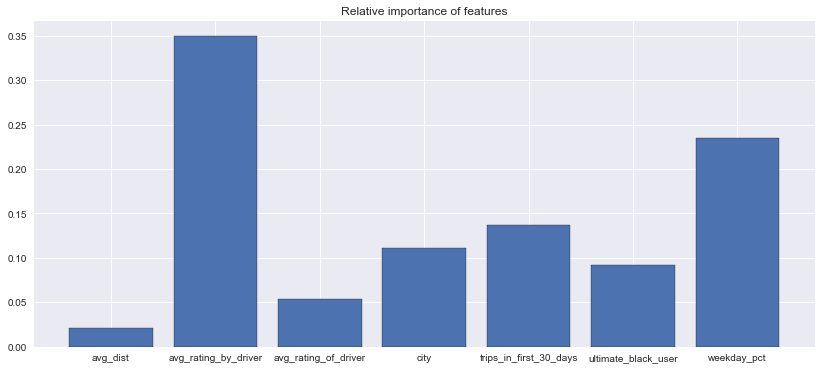

In [256]:
# Recreate our best model
model = RandomForestClassifier(max_depth=4, min_samples_split=100, n_estimators=30, random_state=99)
model.fit(X_train, y_train)
y_true, y_pred = y_test, model.predict(x_test)

# Plot relative importance of features
plt.figure(figsize=(14,6));
plt.bar(df_users.columns[:-1].tolist(), model.feature_importances_);
plt.title('Relative importance of features');

Most important features appear to be average rating <i>by</i> driver and % of user's trips occurring during weekday.

### 2.2.4 Results

<b>Approach.</b> Ultimate's goal is to predict rider retention. Presumably this means they would like to predict users at risk for churn and target them for marketing campaigns, discounts, getting in touch, etc. that would retain these users. 
- As a result, our model emphasizes minimizing false positives (churned users misclassified as 'active' and thus missed by marketing campaigns, etc), while balancing a reasonable amount of false negatives ('active' users misclassified as churners who would then get spammed with these marketing campaigns).

<b>Predicting churned users</b>. Our final model is a <b><i>Random Forest Classifier</i></b>, with {'max_depth': 4, 'min_samples_split': 100, 'n_estimators': 30}. This model does a good job of predicting churned users, with only 1.3% of churners being misclassified as 'active'. 
- The cost is that 21.4% of active users are misclassified as churners, which means they could receive marketing targeted towards churners. However, if this does not result in active users churning (presumably Ultimate adds value sufficiently that they are active users), then this is not necessarily an issue.
- Still, Ultimate should <u>do further tests to determine how detrimental these false negatives are</u> - will active users necessarily churn because they receive ads as well? And at what frequency of ads would active users begin to churn? A balance can probably be struck.

## 2.3 Discussion

How should Ultimate leverage these insights to improve its longterm rider retention? 

The features that were most predictive of 'active'/'inactive' were <b><i>average rating by driver</b></i> and <b><i>percent of user's trips occurring during weekday</b></i>. As a result, our further recommendations to Ultimate are:
- <u>Promote positive driver-rider interaction</u>. It seems lower average rating <i>by</i> driver --> more risk for rider churning. Riders probably had dissatisfactory experiences. Encourage drivers to offer amenities that don't cost them much, such as water, candy, etc. Encourage them to ask a basic set of questions to improve rider mood/reduce likelihood of bad driver interaction, such as offering to roll down window, asking about AC, music, etc. Thus, average rating by driver may improve, resulting in less churning.<p>

- <u>Target churners with weekday discounts</u>. From our analysis, percent of user's trips during weekday is important predictor of churning. Increasing churners' weekday trips may therefore improve likelihood of them remaining customers. This could be accomplished by offering them weekday discounts for their Ultimate trips, making Ultimate more of a weekday routine for them and therefore increasing the likelihood they will remain active users.<p>

- <u>Extend weekday discounts for "worst" churners</u>. Even if some churners only "stay" as long as there is a weekly discount, if Ultimate is not losing money on these customers that would otherwise not use their service and are price-sensitive, it may be useful to extend these discounts for select churners. We recommend Ultimate to identify the most price-sensitive churners.